Source: https://www.itl.nist.gov/div898/handbook/eda/section4/eda426.htm

## Preparation

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\An PC\\jupyter\\eda'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from utils import datasets
from utils import calculations
from utils.plotting import show_and_save_plot
from plots import four_plot, run_sequence_plot, histogram, lag_plot, probability_plot, \
                  autocorrelation_plot

---

# Filter Transmittance
This example illustrates the univariate analysis of filter transmittance data.
1. [Background and Data](#background)
2. [Graphical Output and Interpretation](#graphical)
3. [Quantitative Output and Interpretation](#quantitative)

---

## <a name="background"></a>Background and Data
### Generation 
This data set was collected by NIST chemist Radu Mavrodineaunu in the 1970's from an automatic data acquisition system for a filter transmittance experiment. The response variable is transmittance.

### Motivation
The motivation for studying this data set is to show how the underlying autocorrelation structure in a relatively small data set helped the scientist detect problems with his automatic data acquisition system.

### Data source
https://www.itl.nist.gov/div898/handbook/datasets/MAVRO.DAT

In [3]:
df = datasets.load_filter_transmittance()
df.head()

,transmittance
0,2.0018
1,2.0017
2,2.0018
3,2.0019
4,2.0018


---

## <a name="graphical"></a>Graphical Output and Interpretation
### Goal
The goal of this analysis is threefold:
1. Determine if the univariate model: $Y_i=C+E_i$ is appropriate and valid.
2. Determine if the typical underlying assumptions for an "in control" measurement process are valid. These assumptions are:
    * random drawings;
    * from a fixed distribution;
    * with the distribution having a fixed location; and
    * the distribution having a fixed scale. 
3. Determine if the confidence interval $\bar{Y}\pm\frac{2s}{\sqrt{N}}$ is appropriate and valid where $s$ is the standard deviation of the original data.

### 4-Plot of Data

In [4]:
def four_plot(series, main_title="4-PLOT", show=True, save=False,
              run_kws=None, lag_kws=None, hist_kws=None, prob_kws=None):

    fig, axes = plt.subplots(nrows=2, ncols=2,
                             gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0.3,
                                 },
                             figsize=(7, 8))
    rsp, lag = axes[0]
    hist, prob = axes[1]
    
    # Run Sequence Plot
    run_kws = run_kws if run_kws is not None else {}
    clearance = (max(series)-min(series)) * 1/10
    y_lim = (min(series)-clearance, max(series)+clearance)
    run_sequence_plot(series, y_lim=y_lim, ax=rsp, show=False, **run_kws)

    # Lag Plot
    lag_kws = lag_kws if lag_kws is not None else {}
    lag_plot(series, ax=lag, show=False, **lag_kws)
    
    # Histogram
    hist_kws = hist_kws if hist_kws is not None else {}
    histogram(series, ax=hist, show=False, **hist_kws)

    # Probability Plot
    prob_kws = prob_kws if prob_kws is not None else {}
    probability_plot(series, ax=prob, show=False, **prob_kws)
    
    fig.suptitle(main_title)
    
    show_and_save_plot(show=show, save=save, filename="4-plot.png")

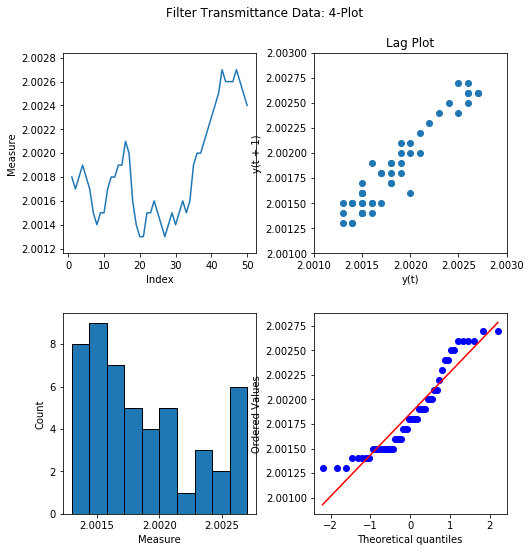

In [5]:
four_plot(df["transmittance"], main_title="Filter Transmittance Data: 4-Plot",
         lag_kws={"x_lim": (2.001, 2.003), "y_lim": (2.001, 2.003)})

### Interpretation
The assumptions are addressed by the graphics shown above:
1. The run sequence plot (upper left) indicates a significant shift in location around *x* = 35.
2. The linear appearance in the lag plot (upper right) indicates a non-random pattern in the data.
3. Since the lag plot indicates significant non-randomness, we do not make any interpretation of either the histogram (lower left) or the normal probability plot (lower right). 

The serious violation of the non-randomness assumption means that the univariate model $Y_i=C+E_i$ is not valid. Given the linear appearance of the lag plot, the first step might be to consider a model of the type $Y_i=A_0+A_1.Y_{i-1}+E_i$. 

However, in this case discussions with the scientist revealed that non-randomness was entirely unexpected. An examination of the experimental process revealed that the sampling rate for the automatic data acquisition system was too fast. That is, the equipment did not have sufficient time to reset before the next sample started, resulting in the current measurement being contaminated by the previous measurement. The solution was to rerun the experiment allowing more time between samples.

Simple graphical techniques can be quite effective in revealing unexpected results in the data. When this occurs, it is important to investigate whether the unexpected result is due to problems in the experiment and data collection or is indicative of unexpected underlying structure in the data. This determination cannot be made on the basis of statistics alone. The role of the graphical and statistical analysis is to detect problems or unexpected results in the data. Resolving the issues requires the knowledge of the scientist or engineer.

### Individual Plots
Although it is generally unnecessary, the plots can be generated individually to give more detail. Since the lag plot indicates significant non-randomness, we omit the distributional plots.

#### Run Sequence Plot 

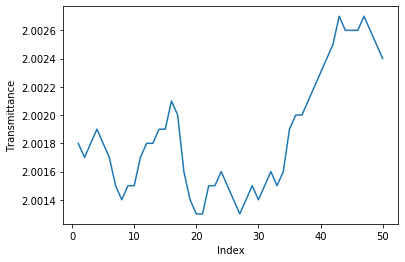

In [6]:
run_sequence_plot(df["transmittance"], y_label="Transmittance")

#### Lag Plot

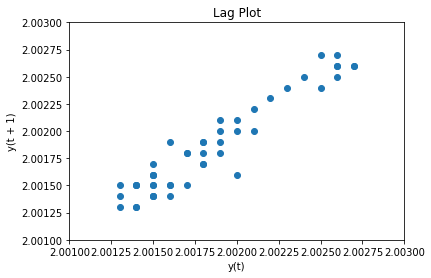

In [7]:
lag_plot(df["transmittance"], x_lim=(2.001, 2.003), y_lim=(2.001, 2.003))

---

## <a name="quantitative"></a>Quantitative Output and Interpretation

### Summary Statistics
As a first step in the analysis, common summary statistics are computed from the data.

In [8]:
df.describe()

,transmittance
count,50.000000
mean,2.001856
std,0.000429
min,2.001300
25%,2.001500
50%,2.001800
75%,2.002100
max,2.002700


### Location
One way to quantify a change in location over time is to fit a straight line to the data using an index variable as the independent variable in the regression. For our data, we assume that data are in sequential run order and that the data were collected at equally spaced time intervals. In our regression, we use the index variable $X = 1, 2, ..., N$, where $N$ is the number of observations. If there is no significant drift in the location over time, the slope parameter should be zero. 

In [9]:
Y = df["transmittance"]
X = df.index.values + 1
X = sm.add_constant(X)

In [10]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          transmittance   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     31.15
Date:                Mon, 30 Sep 2019   Prob (F-statistic):           1.09e-06
Time:                        20:33:16   Log-Likelihood:                 329.75
No. Observations:                  50   AIC:                            -655.5
Df Residuals:                      48   BIC:                            -651.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0014   9.69e-05   2.06e+04      0.0

In [11]:
SSR = np.sqrt(results.mse_resid)
print("Residual Standard Deviation =", SSR)
print("Residual Degrees of Freedom =", results.df_resid)

Residual Standard Deviation = 0.00033763168995702084
Residual Degrees of Freedom = 48.0


The slope parameter, $B_1$, has a *t* value of 5.582, which is statistically significant. Although the estimated slope, 0.185E-04, is nearly zero, the range of data (2.0013 to 2.0027) is also very small. In this case, we conclude that there is drift in location, although it is relatively small.

### Variation
One simple way to detect a change in variation is with a __Bartlett test__ after dividing the data set into several equal-sized intervals. However, the Bartlett test is not robust for non-normality. Since the nature of the data (a few distinct points repeated many times) makes the normality assumption questionable, we use the alternative Levene test. In particular, we use the __Levene test__ based on the median rather the mean. The choice of the number of intervals is somewhat arbitrary, although values of four or eight are reasonable. We will divide our data into four intervals. 

In [12]:
Y = df["transmittance"]
G1, G2, G3, G4 = Y[:13], Y[13:26], Y[26:38], Y[38:]
for G in (Y, G1, G2, G3, G4):
    print(len(G))

50
13
13
12
12


Null and alternative hypothesis

$H_0$:  $\sigma_1^2 = \sigma_2^2 = \sigma_3^2 = \sigma_4^2$

$H_a$:  At least one $\sigma_i^2$ is not equal to the others.

In [13]:
W, p_value = stats.levene(G1, G2, G3, G4)
print("Test statistic =", W)
print("p-value =", p_value)

Test statistic = 1.3799000256848102
p-value = 0.2607857903093207


In this case, Levene test indicates that the variances are not significantly different in the four intervals at the 5% level.

### Randomness
here are many ways in which data can be non-random. However, most common forms of non-randomness can be detected with a few simple tests. The lag plot in the previous section is a simple graphical technique.

Another check is an autocorrelation plot that shows the autocorrelations for various lags. Confidence bands can be plotted at the 95 % and 99 % confidence levels. Points outside this band indicate statistically significant values (lag 0 is always 1).

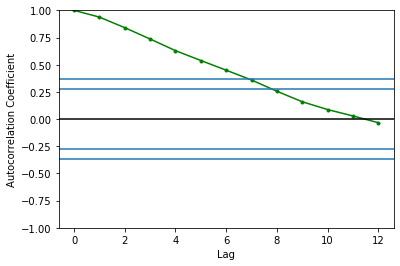

lag = 0, autocorrelation coefficient = 1.000
lag = 1, autocorrelation coefficient = 0.938
lag = 2, autocorrelation coefficient = 0.841
lag = 3, autocorrelation coefficient = 0.737
lag = 4, autocorrelation coefficient = 0.629


In [14]:
coefs, _, _ = autocorrelation_plot(df["transmittance"], max_lag=12, c="green",
                                   marker=".")
for lag, coef in enumerate(coefs[:5]):
    print("lag = {}, autocorrelation coefficient = {:.3f}".format(lag, coef))

The lag 1 autocorrelation, which is generally the one of most interest, is 0.938. The critical values at the 5% level are –0.277 and 0.277. This indicates that the lag 1 autocorrelation is statistically significant, so there is strong evidence of non-randomness.

A common test for randomness is the [Bardley runs test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35d.htm).

*Hypotheses*

>$H_0$:  the sequence was produced in a random manner
>
>$H_a$:  the sequence was not produced in a random manner

*Results*

> Test statistic: $Z = -5.3246$
>
> Significance level: $\alpha = 0.05$
>
> Critical value: $Z_{1-\frac{\alpha}{2}} = 1.96$
>
> Critical region:  Reject $H_0$ if $|{Z}| \gt 1.96$ 

Because the test statistic is outside of the critical region, we reject the null hypothesis and conclude that the data are not random.

### Distributional Analysis
Since we rejected the randomness assumption, the distributional tests are not meaningful. Therefore, these quantitative tests are omitted. We also omit Grubbs' outlier test since it also assumes the data are approximately normally distributed.

### Univariate Report
It is sometimes useful and convenient to summarize the above results in a report.

>__Analysis for Filter Transmittance Data__
>
>
>1. Sample Size = 50
>
>
>2. Location
>
>
>* Mean = 2.001857
>* Standard Deviation of Mean = 0.00006
>* 95% Confidence Interval for Mean = (2.001735,2.001979)
>* Drift with respect to location? = NO
>
>
>3. Variation
>
>
>* Standard Deviation = 0.00043
>* 95% Confidence Interval for SD = (0.000359,0.000535)
>* Change in variation? (based on Levene's test on quarters of the data) = NO
>
>
>4. Distribution
>Distributional tests omitted due to non-randomness of the data.
>
>
>5. Randomness
>
>
>* Lag One Autocorrelation = 0.937998
>* Data are Random? (as measured by autocorrelation)    = NO
>
>
>6. Statistical Control (i.e., no drift in location or scale, data are random, distribution is 
    fixed, here we are testing only for fixed normal)
>
>
>* Data Set is in Statistical Control?   = NO
>
>
>7. Outliers? (Grubbs' test omitted)                = NO

---